In [5]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.5.0
HDF5    1.8.14
Python  2.7.10 (default, Sep 24 2015, 00:07:46) 
[GCC 4.4.5 20110214 (Red Hat 4.4.5-6)]
sys.platform    linux2
sys.maxsize     9223372036854775807
numpy   1.10.1



In [7]:
sys.path.insert(0, '../cbcrom')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)

<module 'chebyshev' from '../cbcrom/chebyshev.pyc'>

# Load ROM

In [8]:
memb_size=2**26-1

# Bamp_filename = '../data/Bamp_cheb_3_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_3_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_3.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_3.hdf5'

# Bamp_filename = '../data/Bamp_cheb_9_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_9_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_9.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_9.hdf5'

Bamp_filename = '../data/Bamp_cheb_16_%d.hdf5'
Bphase_filename = '../data/Bphase_cheb_16_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs_cheb_16.hdf5'
phasecoeff_filename = '../data/phase_coeffs_cheb_16.hdf5'

rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

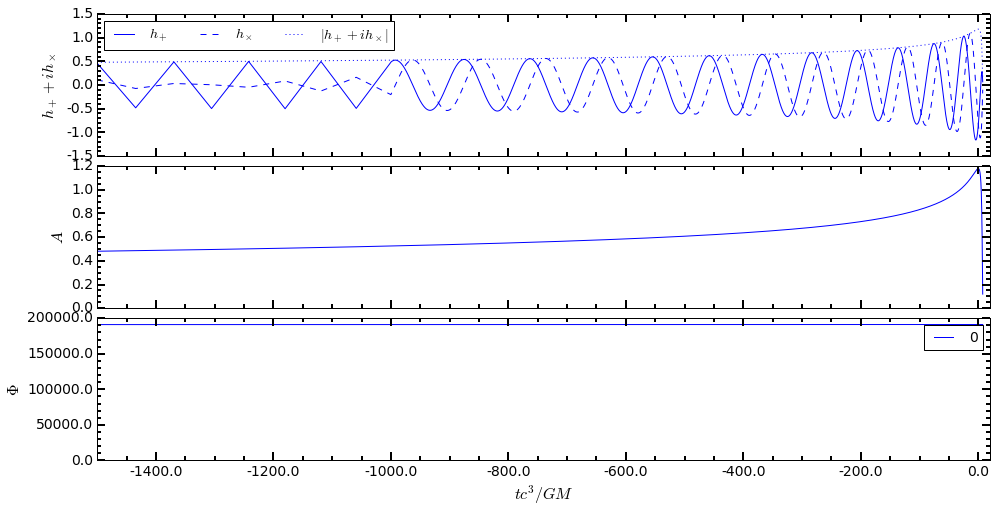

In [9]:
params = [1.0, 50.0, 50.0]
waveforms = rom.evaluate(params)

xlim=[-1500, 20]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

# Useful functions

In [10]:
def plot_time_domain_waveform_difference(fig, h1, h2, imag=False, mag=False,
                                         xlim=None, xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$',
                                         ylabel_pol=r'$h = h_+ + i h_\times$',
                                         ylabel_amp=r'$A_1/A_2 - 1$',
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$'):
    """Plot the amplitude, phase, and polarizations of a waveform.
    """
    
    # Determine the bounds and get indices corresponding to bounds
    imin = 0
    imax = len(h1.time) - 1
    print imin, imax
    if xlim is not None:
        imin = imin if xlim[0]<h1.time[0] else np.argmax(h1.time>xlim[0]) - 1
        imax = imax if xlim[1]>h1.time[-1] else np.argmax(h1.time>xlim[1])
    print imin, imax
    
    # Plot the two waveforms
    axes = fig.add_subplot(311)
    t = h1.time[imin:imax+1]
    h1comp = h1.get_complex()
    axes.plot(t, h1comp[imin:imax+1].real, color='b', ls='-', lw=1, label=h1_legend)
    axes.plot(t, h1comp[imin:imax+1].imag, color='b', ls='-', lw=1)
    axes.plot(t, np.abs(h1comp[imin:imax+1]), color='b', ls='-', lw=1)
    axes.set_xscale('symlog', linthreshx=100.0)

    t = h2.time[imin:imax+1]
    h2comp = h2.get_complex()
    axes.plot(t, h2comp[imin:imax+1].real, color='r', ls='--', lw=1, label=h2_legend)
    axes.plot(t, h2comp[imin:imax+1].imag, color='r', ls='--', lw=1)
    axes.plot(t, np.abs(h2comp[imin:imax+1]), color='r', ls='--', lw=1)
    axes.axhline(y=0.0, color='k', ls=':')
    
    if xlim is not None: axes.set_xlim(xlim)
    axes.set_ylabel(ylabel_pol, fontsize=16)
    axes.xaxis.set_major_formatter(NullFormatter()) # get rid of x-axis numbers
    axes.legend(fontsize=14, loc='best', ncol=3)

    # Amplitude plot
    axes = fig.add_subplot(312)
    error = h1.amp[imin:imax+1]/h2.amp[imin:imax+1] - 1.0
    axes.plot(h1.time[imin:imax+1], error, color='b', ls='-', lw=1)
    axes.set_xscale('symlog', linthreshx=100.0)
    #axes.set_xscale('symlog')
    #axes.set_yscale('symlog', linthreshy=0.001)
    axes.axhline(y=0.0, color='k', ls=':')
    
    if xlim is not None: axes.set_xlim(xlim)
    axes.set_ylabel(ylabel_amp, fontsize=16)
    axes.xaxis.set_major_formatter(NullFormatter()) # get rid of x-axis numbers

    # Phase plot
    axes = fig.add_subplot(313)
    error = h1.phase[imin:imax+1] - h2.phase[imin:imax+1]
    axes.plot(h1.time[imin:imax+1], error, color='b', ls='-', lw=1)
    axes.set_xscale('symlog', linthreshx=100.0)
    #axes.set_xscale('symlog')
    #axes.set_yscale('symlog', linthreshy=0.001)
    axes.axhline(y=0.0, color='k', ls=':')
    
    if xlim is not None: axes.set_xlim(xlim)
    axes.set_xlabel(xlabel, fontsize=16)
    axes.set_ylabel(ylabel_phase, fontsize=16)
    axes.legend(fontsize=14, loc='best', ncol=2)

    subplots_adjust(hspace=0.07)
    
# fig = plt.figure(figsize=(16, 8))
# plot_time_domain_waveform_difference(fig, hrom_res, htrue_res, imag=False, mag=False, 
#                                          xlim=[-2.0e5, 20], xlabel=r'$tc^3/GM$',
#                                          h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
#                                          ylabel_pol=r'$h = h_+ + i h_\times$', 
#                                          ylabel_amp=r'$A_1/A_2 - 1$', 
#                                          ylabel_phase=r'$\Phi_1 - \Phi_2$')

In [11]:
def resample_waveforms_to_match_start_end_times(h1, h2):
    """Resample h1 and h2 so they have the same time samples.
    This function assumes that t=0 corresponds to the maximum amplitude.
    
    Parameters
    ----------
    h1 : TimeDomainWaveform
    h2 : TimeDomainWaveform
    samples_per_cycle : float, 100
    
    Returns
    -------
    h1_new : TimeDomainWaveform
    h2_new : TimeDomainWaveform
    """
    # Copy the waveforms so you don't overwrite them.
    h1_new = h1.copy()
    h2_new = h2.copy()
    
    # Get new start and end times that are common to both waveforms
    t_start = max(h1_new.time[0], h2_new.time[0])
    t_end = min(h1_new.time[-1], h2_new.time[-1])
    
    # Get new time samples from the interval of h1 that also belongs to h2
    t = h1.time
    t_new = np.array([t[i] for i in range(len(t)) if t[i]>t_start and t[i]<t_end])
    
    # Sample evenly in phase
    h1_new.resample_at_times(t_new)
    h2_new.resample_at_times(t_new)
    
    # Shift phase to be 0 at beginning for both
    h1_new.phase_shift(remove_start_phase=True)
    h2_new.phase_shift(remove_start_phase=True)
    
    return h1_new, h2_new

In [12]:
def max_amp_phase_error(htrue, hrom, tmax=None):
    """Calculate the maximum amplitude and phase error of the ROM waveform.
    
    Parameters
    ----------
    hrue : TimeDomainWaveform
    hrom : TimeDomainWaveform
    tmax : float {None}
        Ending time to stop waveform comparison. Uses complete waveform if None.
    """
    # Resample waveforms to have the same times
    #htrue_res, hrom_res = tdwave.resample_waveforms_to_match_start_end_times(htrue, hrom, samples_per_cycle=samples_per_cycle)
    htrue_res, hrom_res = resample_waveforms_to_match_start_end_times(htrue, hrom)
    
    # Relative amplitude error, phase difference error
    amperror = np.abs(hrom_res.amp/htrue_res.amp - 1.0)
    phaseerror = np.abs(hrom_res.phase - htrue_res.phase)
    
    if tmax==None:
        iend = -1
    else:
        iend = next(i for i in range(len(htrue_res.time)) if htrue_res.time[i]>tmax)
    
    iamperrmax = amperror[:iend].argmax()
    tamperrmax = htrue_res.time[iamperrmax]
    amperrmax = amperror[iamperrmax]
    
    iphaseerrmax = phaseerror[:iend].argmax()
    tphaseerrmax = htrue_res.time[iphaseerrmax]
    phaseerrmax = phaseerror[iphaseerrmax]
    
    return iamperrmax, tamperrmax, amperrmax, iphaseerrmax, tphaseerrmax, phaseerrmax

# Check that ROM exactly reproduces the training set waveforms

In [13]:
# Get training set
#ts_filename = '../training_set_cheb_3/teob_runs_cheb_3_%d.hdf5'
#ts_filename = '../training_set_cheb_9/teob_runs_cheb_9_%d.hdf5'
ts_filename = '../training_set_cheb_16/teob_runs_cheb_16_%d.hdf5'

memb_size=2**34-1
ts = tdwave.load_hdf5_time_domain_waveform_set(ts_filename, memb_size=memb_size)

In [10]:
params_ts_list = []
amperr_ts_list = []
phaseerr_ts_list = []

for i in range(ts.get_len()):
    #for i in range(200):
    #print i,
    if i%100==0: print i,
    htrue = ts.get_waveform_data(i)
    
    # Get parameter values and waveform from training_set_rand
    params = ts.get_waveform_data(i, data='parameters')
    
    # Get ROM waveform
    hrom = rom.evaluate(params)
    
    amperr, phaseerr = max_amp_phase_error(htrue, hrom)[2::3]    
    params_ts_list.append(params)
    amperr_ts_list.append(amperr)
    phaseerr_ts_list.append(phaseerr)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000


In [11]:
imax = np.argmax(amperr_ts_list)
print imax, params_ts_list[imax], amperr_ts_list[imax]

imax = np.argmax(phaseerr_ts_list)
print imax, params_ts_list[imax], phaseerr_ts_list[imax]

6 [  5.00000000e-01   5.00000000e+01   1.76018294e+03] 7.6860733397e-05
1857 [  7.23867654e-01   8.68901749e+02   1.04084688e+02] 0.0136702101445


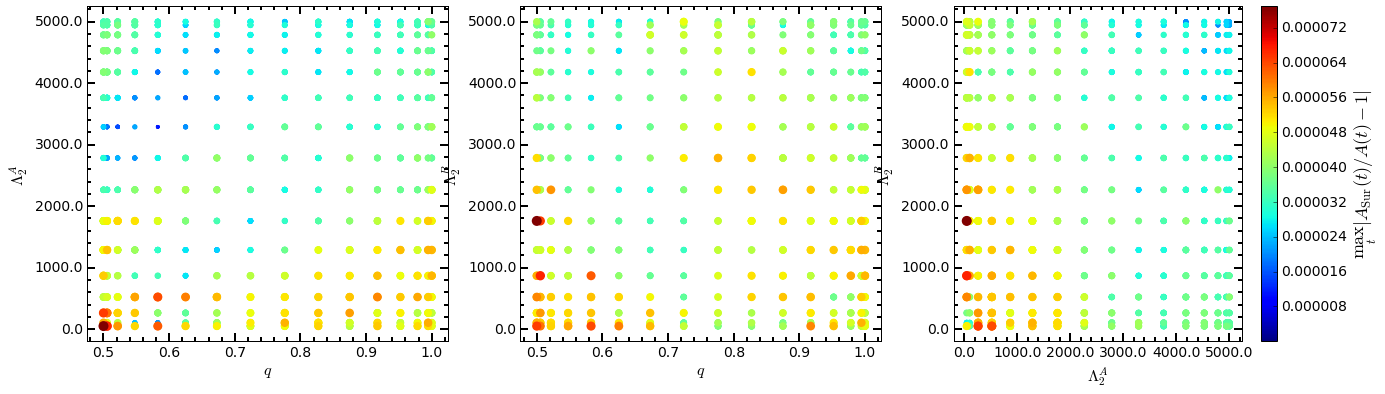

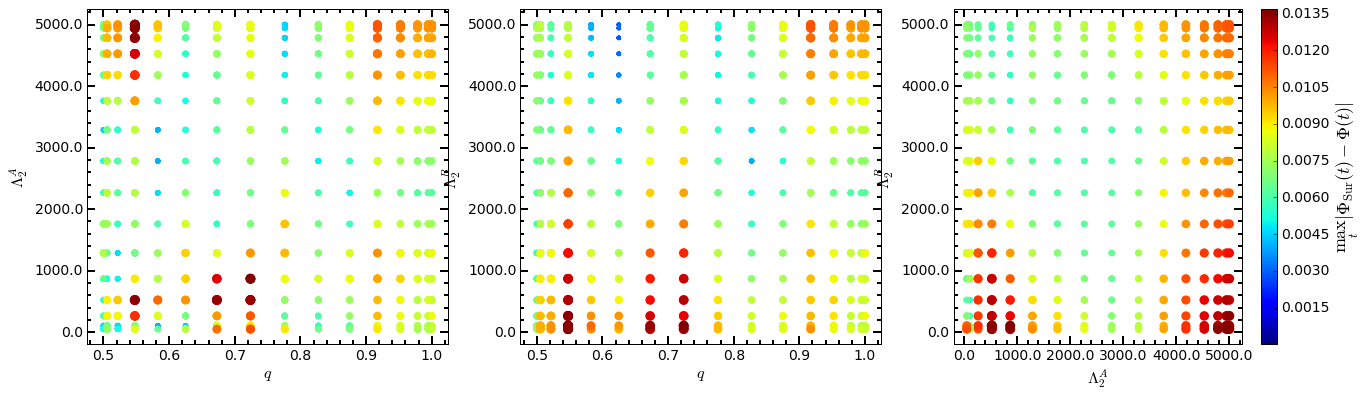

In [12]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_ts_list, amperr_ts_list, 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_ts_list, amperr_ts_list, 0, 2, r'$q$', r'$\Lambda_2^B$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_ts_list, amperr_ts_list, 1, 2, r'$\Lambda_2^A$', r'$\Lambda_2^B$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'$\max_t |A_{\rm Sur}(t)/A(t) - 1|$')


# Phase errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_ts_list, phaseerr_ts_list, 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_ts_list, phaseerr_ts_list, 0, 2, r'$q$', r'$\Lambda_2^B$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_ts_list, phaseerr_ts_list, 1, 2, r'$\Lambda_2^A$', r'$\Lambda_2^B$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'$\max_t|\Phi_{\rm Sur}(t)-\Phi(t)|$')

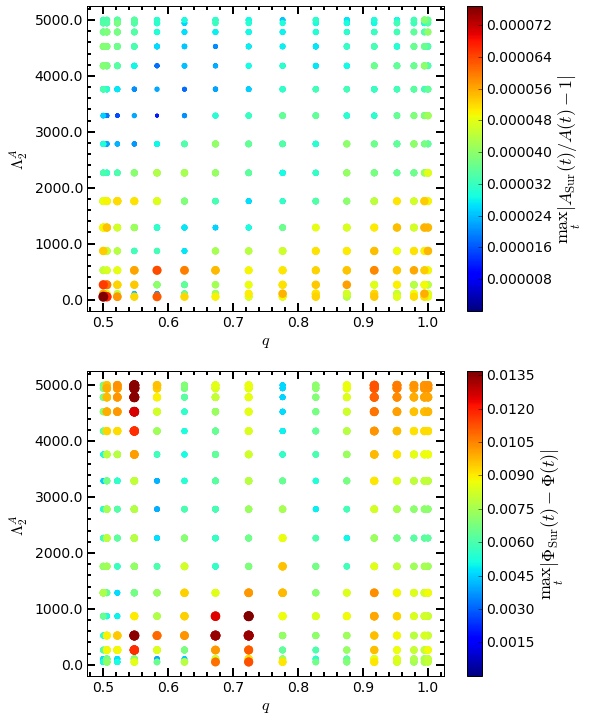

In [13]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(8, 12))

axes = fig.add_subplot(211)
diagnostics.max_error_2d_projection_plot(axes, params_ts_list, amperr_ts_list, 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None,
                                         colorbar=True, colorbarlabel=r'$\max_t |A_{\rm Sur}(t)/A(t) - 1|$')

axes = fig.add_subplot(212)
diagnostics.max_error_2d_projection_plot(axes, params_ts_list, phaseerr_ts_list, 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None,
                                        colorbar=True, colorbarlabel=r'$\max_t|\Phi_{\rm Sur}(t)-\Phi(t)|$')

fig.savefig('/home/bdlackey/public_html/ROM/errorRB.pdf', format='pdf', transparent=True, bbox_inches='tight')

[  7.23867654e-01   8.68901749e+02   1.04084688e+02]
0 73621
144 73621


/home/bdlackey/virtenvs/python-notebook/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


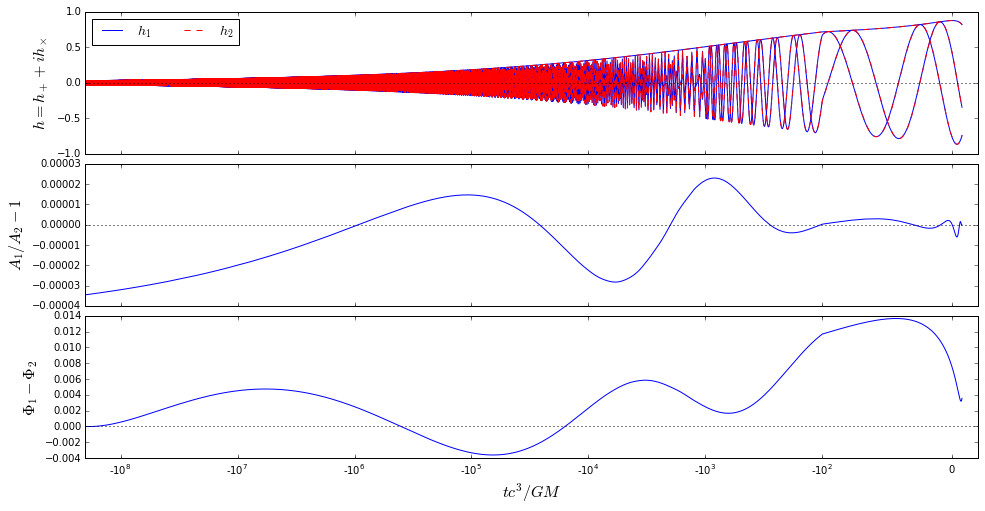

In [14]:
i=1857
params = ts.get_waveform_data(i, data='parameters')
print params
htrue = ts.get_waveform_data(i)

# Get ROM waveform
hrom = rom.evaluate(params)

# Resample so the waveforms are the same
htrue_res, hrom_res = resample_waveforms_to_match_start_end_times(htrue, hrom)

fig = plt.figure(figsize=(16, 8))
plot_time_domain_waveform_difference(fig, hrom_res, htrue_res, imag=False, mag=False, 
                                         xlim=[-2.0e8, 20], xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

# Compare results with randomly sampled waveform set

In [10]:
training_set_dir = '../training_set_rand'
ts_filename = '../training_set_rand/teob_runs_rand_%d.hdf5'

memb_size=2**34-1
param_names = ['q', 'LambdaA', 'LambdaB']

ts_rand = eob.get_eob_training_set_efficient(training_set_dir, ts_filename, memb_size=memb_size, 
                          param_names=param_names, 
                          t_transition=-1000.0, samples_per_cycle=2.0, dt=0.1, t_trunc=6.0e7)
ts_rand.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [11]:
filename = '../training_set_rand/teob_runs_rand_%d.hdf5'
memb_size=2**34-1
ts_rand = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

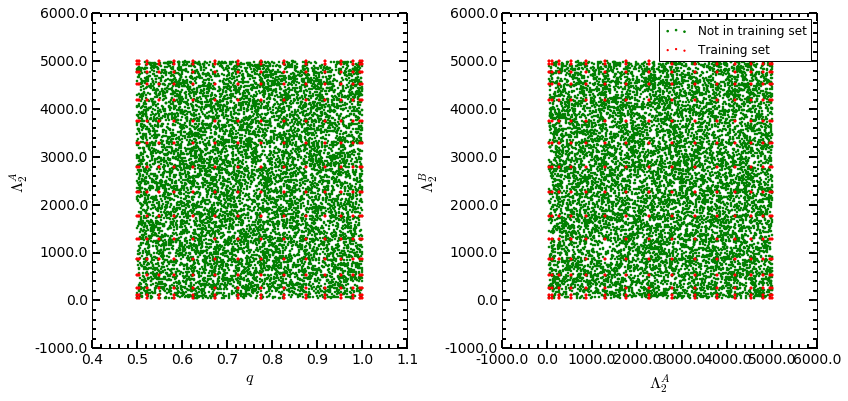

In [12]:
fig = plt.figure(figsize=(13, 6))

axes = fig.add_subplot(121)
axes.scatter(np.array(ts_rand.get_parameters())[:, 0], np.array(ts_rand.get_parameters())[:, 1], 
             marker='.', s=10, color='g')
axes.scatter(np.array(ts.get_parameters())[:, 0], np.array(ts.get_parameters())[:, 1], 
             marker='.', s=6, color='r')
axes.set_xlabel(r'$q$', fontsize=16)
axes.set_ylabel(r'$\Lambda_2^A$', fontsize=16)
axes.set_xticklabels(axes.get_xticks(), fontsize=14)
axes.set_yticklabels(axes.get_yticks(), fontsize=14)
axes.minorticks_on()
axes.tick_params(which='major', width=2, length=8)
axes.tick_params(which='minor', width=2, length=4)


axes = fig.add_subplot(122)
axes.scatter(np.array(ts_rand.get_parameters())[:, 1], np.array(ts_rand.get_parameters())[:, 2], 
             marker='.', s=10, color='g', label='Not in training set')
axes.scatter(np.array(ts.get_parameters())[:, 1], np.array(ts.get_parameters())[:, 2], 
             marker='.', s=6, color='r', label='Training set')
axes.set_xlabel(r'$\Lambda_2^A$', fontsize=16)
axes.set_ylabel(r'$\Lambda_2^B$', fontsize=16)
axes.set_xticklabels(axes.get_xticks(), fontsize=14)
axes.set_yticklabels(axes.get_yticks(), fontsize=14)
axes.minorticks_on()
axes.tick_params(which='major', width=2, length=8)
axes.tick_params(which='minor', width=2, length=4)
axes.legend()

subplots_adjust(wspace=0.3)

In [18]:
# Amplitude and phase error for each verification waveform maximized over time
params_rand_list = []
amperr_rand_list = []
phaseerr_rand_list = []

for i in range(ts_rand.get_len()):
    #for i in range(100):
    #print i,
    if i%100==0: print i,
    htrue = ts_rand.get_waveform_data(i)
    
    # Get parameter values and waveform from training_set_rand
    params = ts_rand.get_waveform_data(i, data='parameters')
    
    # Get ROM waveform
    hrom = rom.evaluate(params)
    
    amperr, phaseerr = max_amp_phase_error(htrue, hrom)[2::3]    
    params_rand_list.append(params)
    amperr_rand_list.append(amperr)
    phaseerr_rand_list.append(phaseerr)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900


In [43]:
# Amplitude and phase error for each verification waveform maximized over time up to t/M = -100
params_rand_tmax_list = []
amperr_rand_tmax_list = []
phaseerr_rand_tmax_list = []

for i in range(ts_rand.get_len()):
    #for i in range(1000):
    #print i,
    if i%100==0: print i,
    htrue = ts_rand.get_waveform_data(i)
    
    # Get parameter values and waveform from training_set_rand
    params = ts_rand.get_waveform_data(i, data='parameters')
    
    # Get ROM waveform
    hrom = rom.evaluate(params)
    
    amperr, phaseerr = max_amp_phase_error(htrue, hrom, tmax=-100.0)[2::3]    
    params_rand_tmax_list.append(params)
    amperr_rand_tmax_list.append(amperr)
    phaseerr_rand_tmax_list.append(phaseerr)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900


In [19]:
imax = np.argmax(amperr_rand_list)
print imax, params_rand_list[imax], amperr_rand_list[imax]

imax = np.argmax(phaseerr_rand_list)
print imax, params_rand_list[imax], phaseerr_rand_list[imax]

3552 [   0.67790957  157.938424     61.995736  ] 0.0383246309902
2274 [   0.61787589  419.899052     81.108529  ] 0.043143954128


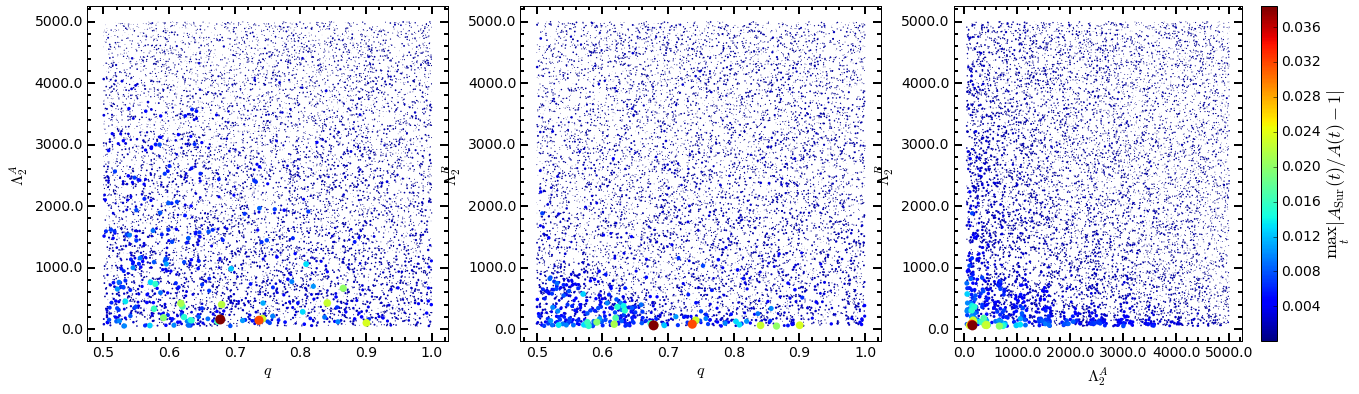

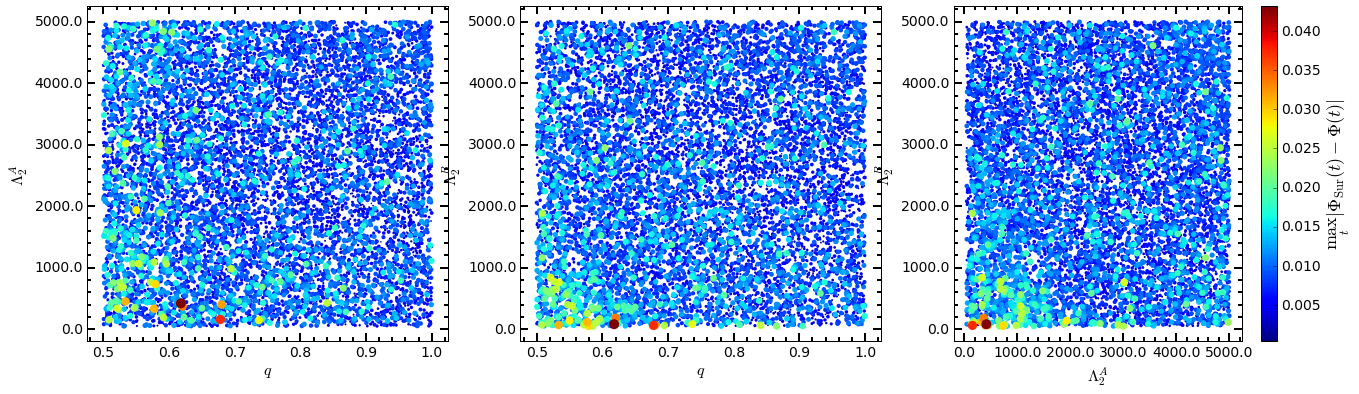

In [20]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_rand_list, amperr_rand_list, 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_rand_list, amperr_rand_list, 0, 2, r'$q$', r'$\Lambda_2^B$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_rand_list, amperr_rand_list, 1, 2, r'$\Lambda_2^A$', r'$\Lambda_2^B$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'$\max_t |A_{\rm Sur}(t)/A(t) - 1|$')


# Phase errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_rand_list, phaseerr_rand_list, 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_rand_list, phaseerr_rand_list, 0, 2, r'$q$', r'$\Lambda_2^B$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_rand_list, phaseerr_rand_list, 1, 2, r'$\Lambda_2^A$', r'$\Lambda_2^B$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'$\max_t|\Phi_{\rm Sur}(t)-\Phi(t)|$')

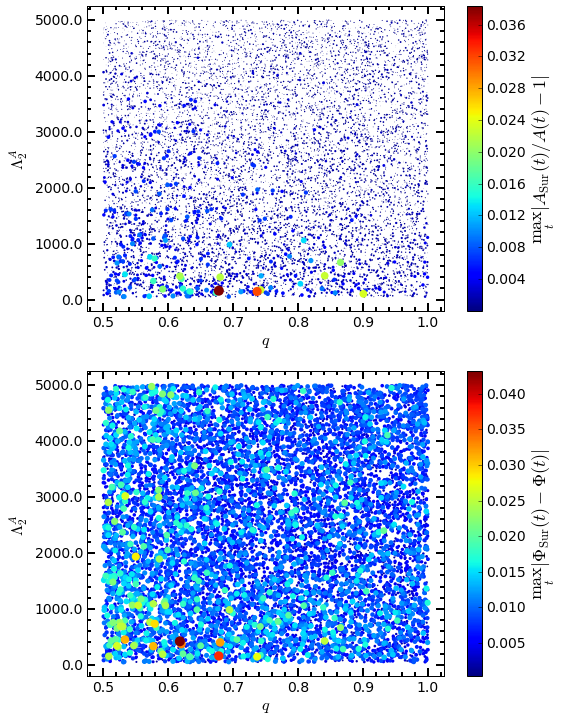

In [21]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(8, 12))

axes = fig.add_subplot(211)
diagnostics.max_error_2d_projection_plot(axes, params_rand_list, amperr_rand_list, 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None,
                                         colorbar=True, colorbarlabel=r'$\max_t |A_{\rm Sur}(t)/A(t) - 1|$')

axes = fig.add_subplot(212)
diagnostics.max_error_2d_projection_plot(axes, params_rand_list, phaseerr_rand_list, 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None,
                                        colorbar=True, colorbarlabel=r'$\max_t|\Phi_{\rm Sur}(t)-\Phi(t)|$')

fig.savefig('/home/bdlackey/public_html/ROM/errorROM.pdf', format='pdf', transparent=True, bbox_inches='tight')

[   0.61787589  419.899052     81.108529  ]
0 65360
0 65360


/home/bdlackey/virtenvs/python-notebook/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


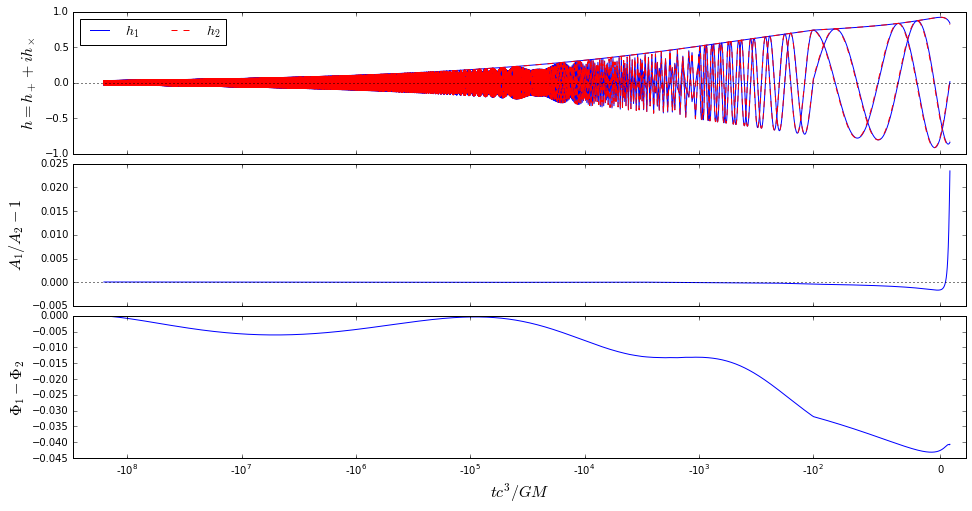

In [13]:
#i = 3552
i = 2274
params = ts_rand.get_waveform_data(i, data='parameters')
print params
htrue = ts_rand.get_waveform_data(i)

# Get ROM waveform
hrom = rom.evaluate(params)

# Resample so the waveforms are the same
#htrue_res, hrom_res = tdwave.resample_waveforms_to_match_start_end_times(htrue, hrom, samples_per_cycle=20)
htrue_res, hrom_res = resample_waveforms_to_match_start_end_times(htrue, hrom)

# Compare ROM to the true waveform
fig = plt.figure(figsize=(16, 8))
plot_time_domain_waveform_difference(fig, htrue_res, hrom_res, imag=False, mag=False, 
                                         xlim=[-3.0e8, 20], xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')

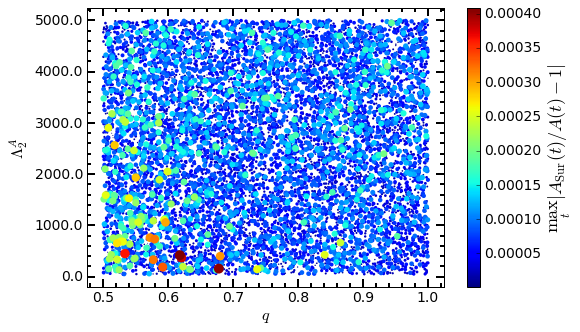

In [45]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(8, 5))

axes = fig.add_subplot(111)
diagnostics.max_error_2d_projection_plot(axes, params_rand_tmax_list, amperr_rand_tmax_list, 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None,
                                         colorbar=True, colorbarlabel=r'$\max_t |A_{\rm Sur}(t)/A(t) - 1|$')

fig.savefig('/home/bdlackey/public_html/ROM/errorAmp100M.pdf', format='pdf', transparent=True, bbox_inches='tight')

# axes = fig.add_subplot(212)
# diagnostics.max_error_2d_projection_plot(axes, params_rand_tmax_list, phaseerr_rand_tmax_list, 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None,
#                                         colorbar=True, colorbarlabel=r'$\max_t|\Phi_{\rm Sur}(t)-\Phi(t)|$')

#fig.savefig('/home/bdlackey/public_html/ROM/errorROM.pdf', format='pdf', transparent=True, bbox_inches='tight')

In [13]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

[   0.61787589  419.899052     81.108529  ]


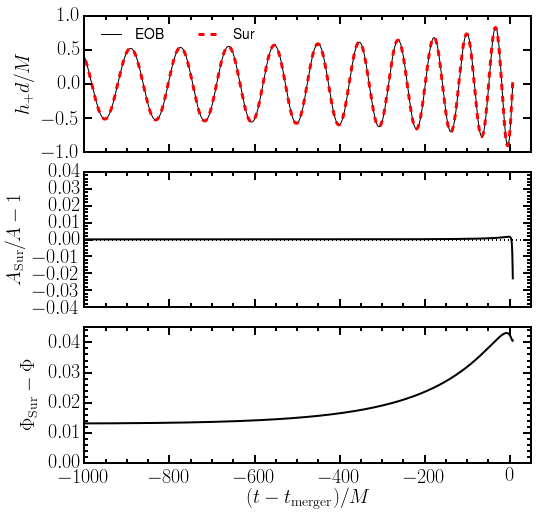

In [14]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

pyplot.rcParams.update({'xtick.direction': 'in', 'ytick.direction': 'in'})

#i = 3552
i = 2274

params = ts_rand.get_waveform_data(i, data='parameters')
print params
htrue = ts_rand.get_waveform_data(i)
hrom = rom.evaluate(params)

# Resample so the waveforms are the same
htrue_res, hrom_res = resample_waveforms_to_match_start_end_times(htrue, hrom)
h1 = htrue_res
h2 = hrom_res

fig, ax = plt.subplots(3, sharex=True, figsize=(8, 8))

h1comp = h1.get_complex()
h2comp = h2.get_complex()
ax[0].plot(h1.time, h1comp.real, color='k', ls='-', lw=1, label='EOB')
ax[0].plot(h2.time, h2comp.real, color='r', ls='--', lw=3, label='Sur')
ax[0].set_xlim(-1.0e3, 50)
ax[0].set_ylim(-1, 1)
ax[0].set_ylabel(r'$h_+d/M$')
l = ax[0].legend(loc='upper left', ncol=2, frameon=False)
l.set_zorder(0)

# Amplitude plot
error = h2.amp/h1.amp - 1.0
ax[1].plot(h1.time, error, c='k', ls='-', lw=2)
ax[1].axhline(y=0.0, color='k', ls=':', lw=2)
ax[1].set_ylim(-0.04, 0.04)
ax[1].set_ylabel(r'$A_{\rm Sur}/A - 1$')
ax[1].yaxis.set_major_locator(MultipleLocator(0.01))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.002))

# Phase plot
error = h2.phase - h1.phase
ax[2].plot(h1.time, error, c='k', ls='-', lw=2)
ax[2].axhline(y=0.0, color='k', ls=':', lw=2)
ax[2].set_xlabel(r'$(t-t_{\rm merger})/M$')
ax[2].set_ylabel(r'$\Phi_{\rm Sur} - \Phi$')
ax[2].yaxis.set_major_locator(MultipleLocator(0.01))
ax[2].yaxis.set_minor_locator(MultipleLocator(0.002))
ax[2].xaxis.set_minor_locator(MultipleLocator(50))

subplots_adjust(hspace=0.15)

fig.savefig('/home/bdlackey/public_html/ROM/waveformmaxerror.pdf', format='pdf', transparent=True, bbox_inches='tight')

[   0.67790957  157.938424     61.995736  ]


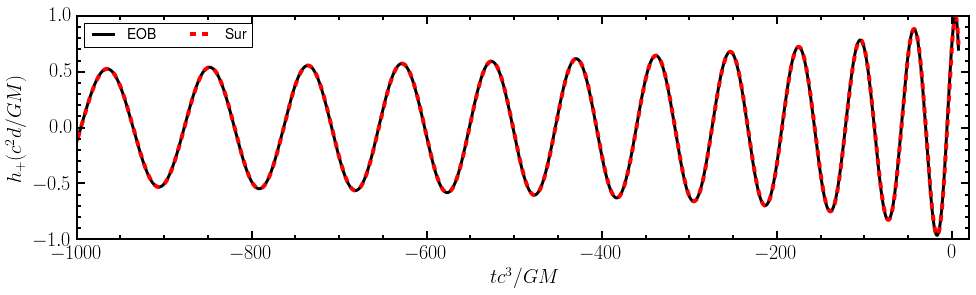

In [25]:
# Worst fit amplitude
i = 3552
#i = 2274

params = ts_rand.get_waveform_data(i, data='parameters')
print params
htrue = ts_rand.get_waveform_data(i)
hrom = rom.evaluate(params)

# Resample so the waveforms are the same
htrue_res, hrom_res = resample_waveforms_to_match_start_end_times(htrue, hrom)
h1 = htrue_res
h2 = hrom_res

fig, axes = plt.subplots(1, figsize=(16, 4))

h1comp = h1.get_complex()
h2comp = h2.get_complex()
axes.plot(h1.time, h1comp.real, color='k', ls='-', lw=3, label='EOB')
axes.plot(h2.time, h2comp.real, color='r', ls='--', lw=4, label='Sur')
# axes.plot(h1.time, np.abs(h1comp), color='k', ls='-', lw=3)
# axes.plot(h2.time, np.abs(h1comp), color='r', ls='--', lw=4)
axes.minorticks_on()
axes.set_xlim(-1.0e3, 20)
axes.set_ylim(-1, 1)
axes.set_xlabel(r'$tc^3/GM$')
axes.set_ylabel(r'$h_+ (c^2d/GM)$')
axes.legend(loc='best', ncol=2)

[   0.61787589  419.899052     81.108529  ]


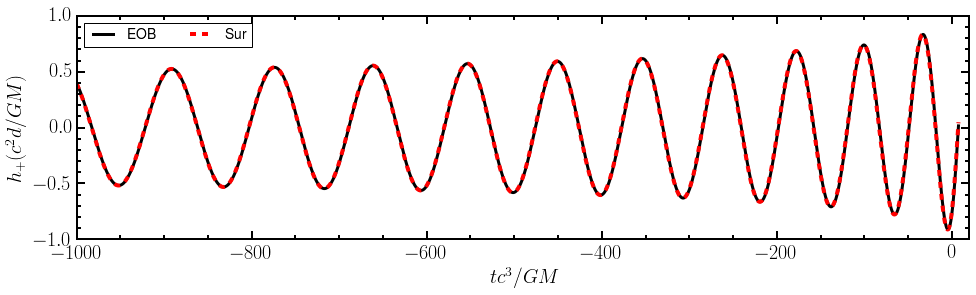

In [26]:
# Worst fit phase
#i = 3552
i = 2274

params = ts_rand.get_waveform_data(i, data='parameters')
print params
htrue = ts_rand.get_waveform_data(i)
hrom = rom.evaluate(params)

# Resample so the waveforms are the same
htrue_res, hrom_res = resample_waveforms_to_match_start_end_times(htrue, hrom)
h1 = htrue_res
h2 = hrom_res

fig, axes = plt.subplots(1, figsize=(16, 4))

h1comp = h1.get_complex()
h2comp = h2.get_complex()
axes.plot(h1.time, h1comp.real, color='k', ls='-', lw=3, label='EOB')
axes.plot(h2.time, h2comp.real, color='r', ls='--', lw=4, label='Sur')
# axes.plot(h1.time, np.abs(h1comp), color='k', ls='-', lw=3)
# axes.plot(h2.time, np.abs(h1comp), color='r', ls='--', lw=4)
axes.minorticks_on()
axes.set_xlim(-1.0e3, 20)
axes.set_ylim(-1, 1)
axes.set_xlabel(r'$tc^3/GM$')
axes.set_ylabel(r'$h_+ (c^2d/GM)$')
axes.legend(loc='best', ncol=2)

# Chebyshev coefficients

In [ ]:
def chebyshev_interpolation3d_coefficients(f_ijk, params_min, params_max):
    """Generate a function of N parameters that interpolates a uniformly spaced Nd array.
    
    Parameters
    ----------
    data : 3d array
        Data to interpolate.
    params_min : 1d array of length 3
        Minimum value of each parameter.
    params_max : 1d array of length 3
        Maximum value of each parameter.
    
    Returns
    -------
    interp: function(params)
        Interpolating function that takes params
        (1d array of the parameter values at which you want to interpolate the data).
    """
    cheb_approx = cheb.ChebyshevApproximation()
    # Get the bounds of the parameter space
    cheb_approx.low = params_min
    cheb_approx.high = params_max
    cheb_approx.Ndim = 3
    cheb_approx.f_grid = f_ijk
    # Calculate the Chebyshev coefficients
    cheb_approx.calculate_chebyshev_coefficients()
    
    return cheb_approx.coefficients

In [ ]:
nodei = 7

f_ijk = train_phase_grid[..., nodei]
params = param_grid
params_min = params[0, 0, 0]
params_max = params[-1, -1, -1]
c_lmn = chebyshev_interpolation3d_coefficients(f_ijk, params_min, params_max)

In [ ]:
#carray = np.array([[i, np.abs(c_lmn[i, i, i])] for i in range(len(c_lmn))])

In [ ]:
#carray = np.array([[i, np.max(np.abs(c_lmn[i, :, :].flatten()))] for i in range(len(c_lmn))])

### Make a plot like this for the coefficients of known functions and see how the value drops with the index

In [ ]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(111)

carray = np.array([[i, np.max(np.abs(c_lmn[i, :, :].flatten()))] for i in range(len(c_lmn))])
axes.semilogy(carray[:, 0], carray[:, 1], ls='-', lw=1.5, 
              label=r'$\max_{j,k}|c_{ijk}|$')

carray = np.array([[i, np.max(np.abs(c_lmn[:, i, :].flatten()))] for i in range(len(c_lmn))])
axes.semilogy(carray[:, 0], carray[:, 1], ls='-', lw=1.5, 
              label=r'$\max_{i,k}|c_{ijk}|$')

carray = np.array([[i, np.max(np.abs(c_lmn[:, :, i].flatten()))] for i in range(len(c_lmn))])
axes.semilogy(carray[:, 0], carray[:, 1], ls='-', lw=1.5, 
              label=r'$\max_{i, j}|c_{ijk}|$')

axes.set_xlabel(r'coefficient index', fontsize=16)
axes.set_ylabel(r'Phase coefficients', fontsize=16)
axes.set_xticklabels(axes.get_xticks(), fontsize=14)
axes.set_yticklabels(axes.get_yticks(), fontsize=14)
axes.minorticks_on()
axes.tick_params(which='major', width=2, length=8)
axes.tick_params(which='minor', width=2, length=4)
axes.legend(fontsize=16, loc='best')

In [ ]:
def plot_greedy_error(axes, sigma_list):
    """Plot the greedy error as a function of the number of reduced bases.
    
    Parameters
    ----------
    axes : axes object
        The axes you want to put the plot on.
    sigma_list : list of floats
        The greedy errors
    """
    
    axes.semilogy(sigma_list, color='k', ls='-', lw=1.5)
    #axes.semilogy(sigma_list, color='b', marker='o')
    
    axes.set_xlabel(r'Waveform index $m$', fontsize=16)
    axes.set_ylabel(r'Greedy error $\sigma_m$', fontsize=16)
    axes.set_xticklabels(axes.get_xticks(), fontsize=14)
    axes.set_yticklabels(axes.get_yticks(), fontsize=14)
    axes.minorticks_on()
    axes.tick_params(which='major', width=2, length=8)
    axes.tick_params(which='minor', width=2, length=4)


# Old Junk

In [37]:
def plot_time_domain_waveform_difference(fig, h1, h2, imag=False, mag=False,
                                         xlim=None, xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$',
                                         ylabel_pol=r'$h = h_+ + i h_\times$',
                                         ylabel_amp=r'$A_1/A_2 - 1$',
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$'):
    """Plot the amplitude, phase, and polarizations of a waveform.
    """
    
    # Determine the bounds and get indices corresponding to bounds
    imin = 0
    imax = len(h1.time) - 1
    print imin, imax
    if xlim is not None:
        imin = imin if xlim[0]<h1.time[0] else np.argmax(h1.time>xlim[0]) - 1
        imax = imax if xlim[1]>h1.time[-1] else np.argmax(h1.time>xlim[1])
    print imin, imax
    
    # Plot the two waveforms
    axes = fig.add_subplot(311)
    t = h1.time[imin:imax+1]
    h1comp = h1.get_complex()
    axes.plot(t, h1comp[imin:imax+1].real, color='b', ls='-', lw=1, label=h1_legend)
    axes.plot(t, h1comp[imin:imax+1].imag, color='b', ls='-', lw=1)
    axes.plot(t, np.abs(h1comp[imin:imax+1]), color='b', ls='-', lw=1)
    #axes.set_xscale('symlog', linthreshx=100.0)

    t = h2.time[imin:imax+1]
    h2comp = h2.get_complex()
    axes.plot(t, h2comp[imin:imax+1].real, color='r', ls='--', lw=1, label=h2_legend)
    axes.plot(t, h2comp[imin:imax+1].imag, color='r', ls='--', lw=1)
    axes.plot(t, np.abs(h2comp[imin:imax+1]), color='r', ls='--', lw=1)
    axes.axhline(y=0.0, color='k', ls=':')
    
    if xlim is not None: axes.set_xlim(xlim)
    axes.set_ylabel(ylabel_pol, fontsize=16)
    axes.xaxis.set_major_formatter(NullFormatter()) # get rid of x-axis numbers
    axes.legend(loc='best', ncol=3)

    # Amplitude plot
    axes = fig.add_subplot(312)
    error = h1.amp[imin:imax+1]/h2.amp[imin:imax+1] - 1.0
    axes.plot(h1.time[imin:imax+1], error, color='b', ls='-', lw=1)
    axes.set_xscale('symlog', linthreshx=100.0)
    #axes.set_xscale('symlog')
    #axes.set_yscale('symlog', linthreshy=0.001)
    axes.axhline(y=0.0, color='k', ls=':')
    
    if xlim is not None: axes.set_xlim(xlim)
    axes.set_ylabel(ylabel_amp, fontsize=16)
    axes.xaxis.set_major_formatter(NullFormatter()) # get rid of x-axis numbers

    # Phase plot
    axes = fig.add_subplot(313)
    error = h1.phase[imin:imax+1] - h2.phase[imin:imax+1]
    axes.plot(h1.time[imin:imax+1], error, color='b', ls='-', lw=1)
    axes.set_xscale('symlog', linthreshx=100.0)
    #axes.set_xscale('symlog')
    #axes.set_yscale('symlog', linthreshy=0.001)
    axes.axhline(y=0.0, color='k', ls=':')
    
    if xlim is not None: axes.set_xlim(xlim)
    axes.set_xlabel(xlabel, fontsize=16)
    axes.set_ylabel(ylabel_phase, fontsize=16)
    axes.legend(loc='best', ncol=2)

    subplots_adjust(hspace=0.07)

In [ ]:
i=634
params = ts_rand.get_waveform_data(i, data='parameters')
print params
htrue = ts_rand.get_waveform_data(i)

# Get ROM waveform
hrom = rom.evaluate(params)

# Resample so the waveforms are the same
#htrue_res, hrom_res = tdwave.resample_waveforms_to_match_start_end_times(htrue, hrom, samples_per_cycle=20)
htrue_res, hrom_res = resample_waveforms_to_match_start_end_times(htrue, hrom)

# Compare ROM to the true waveform
fig = plt.figure(figsize=(16, 8))
plot_time_domain_waveform_difference(fig, htrue_res, hrom_res, imag=False, mag=False, 
                                         xlim=[-1000, 20], xlabel=r'$tc^3/GM$',
                                         h1_legend=r'$h_1$', h2_legend=r'$h_2$', 
                                         ylabel_pol=r'$h = h_+ + i h_\times$', 
                                         ylabel_amp=r'$A_1/A_2 - 1$', 
                                         ylabel_phase=r'$\Phi_1 - \Phi_2$')